<h1>Parameter space exploration</h1>

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from scipy.stats import *
%matplotlib nbagg

import os, sys
root_dir = os.path.dirname(os.path.abspath(''))
if not root_dir in sys.path: sys.path.append(root_dir)
from DM_theory import *
from general.helper import *

In [2]:
def lognormal_distr(x,mu,sigma):
    
    print(f'in logn: mu={mu}')
    
    return 1. / (x * sigma * np.sqrt(2 * np.pi)) * np.exp(- (np.log(x)-mu)**2 / (2*sigma**2))

In [7]:
import math
import numpy as np
class trunc_logn:
    
    ## x: variable
    ## mu, sigma: parameters of lognormal distribution - NOT mean / variance
    mu = math.nan
    sigma = math.nan
    
    ## a: lower point of truncation
    a = 0
    ## b: upper point of truncation    
    b = math.inf
    
    def __init__(self,mu,sigma,a,b):
        self.mu = mu
        self.sigma = sigma
        self.a = a
        self.b = b
        
        self.Phi_val = self.Phi()
    
    def change_params(self,mu=None,sigma=None,a=None,b=None):
        
        self.mu = self.mu if mu==None else mu
        self.sigma = self.sigma if sigma==None else sigma
        self.a = self.a if a==None else a
        self.b = self.b if b==None else b
    
    def set_with_moments(self,mean,q):
        
        self.mu = np.log(mean**2/np.sqrt(q))
        self.sigma = np.sqrt(np.log(q/mean**2))
        print(f'mu: {self.mu}, sigma: {self.sigma}')
        
        
    def Phi(self):
        return 1/2 * (1 + math.erf((math.log(self.b) - self.mu)/(math.sqrt(2)*self.sigma)))
        
    def pdf(self,x):
        
        return 1/(math.sqrt(2*math.pi)*self.sigma * x) * np.exp(-(np.log(x) - self.mu)**2/(2*self.sigma**2)) / self.Phi_val
        
    def mean(self):
        return 1/(2 * self.Phi_val) * math.exp(self.mu + self.sigma**2/2) * \
                (1 + math.erf((math.log(self.b) - self.mu - self.sigma**2)/(math.sqrt(2)*self.sigma)))
    
    def variance(self):
        return 1/(2 * self.Phi_val) * math.exp(2*self.mu + 2*self.sigma**2) * \
                (1 + math.erf((math.log(self.b) - self.mu - 2*self.sigma**2)/(math.sqrt(2)*self.sigma)))

In [4]:
from scipy.optimize import fsolve

steps = 10000

mean = 0.5
q = 3.


f = trunc_logn(mu,sigma,0,15.)
nu = np.linspace(10/(steps+1),10,steps)

plt.figure()
plt.plot(nu,f.pdf(nu))

f.set_with_moments(1.5,3.)
plt.plot(nu,f.pdf(nu))

plt.axvline(mean,color='r',ls='--')
plt.show()



NameError: name 'mu' is not defined

<IPython.core.display.Javascript object>


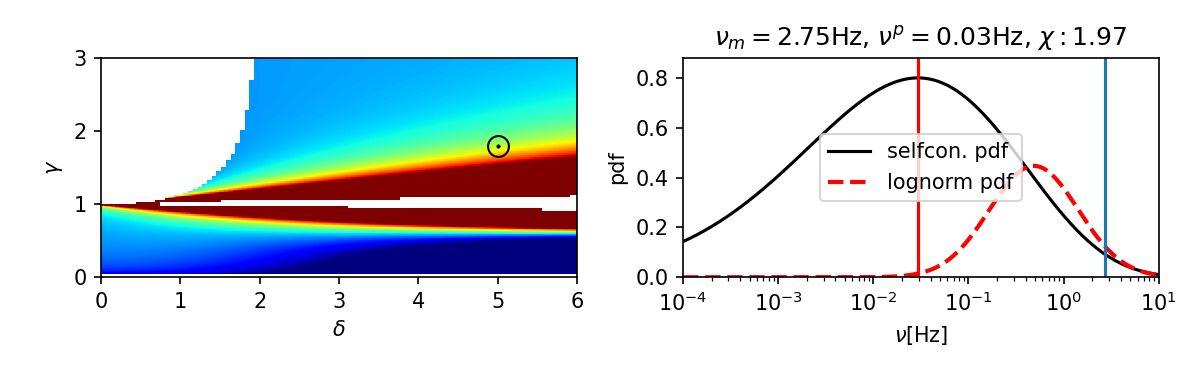

[1.00000000e-04 1.00138251e-04 1.00276692e-04 ... 9.97240712e+01
 9.98619403e+01 1.00000000e+02]
mu: 0.0, sigma: 0.0


/tmp/ipykernel_26268/2157323539.py:42: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(math.sqrt(2*math.pi)*self.sigma * x) * np.exp(-(np.log(x) - self.mu)**2/(2*self.sigma**2)) / self.Phi_val
/tmp/ipykernel_26268/2157323539.py:42: RuntimeWarning: invalid value encountered in multiply
  return 1/(math.sqrt(2*math.pi)*self.sigma * x) * np.exp(-(np.log(x) - self.mu)**2/(2*self.sigma**2)) / self.Phi_val


interactive(children=(FloatSlider(value=1.8, description='$\\displaystyle \\gamma$', max=3.0, step=0.01), Floa…

In [10]:
gamma = 1.8
delta = 5



fig,ax = plt.subplots(1,2,figsize=(8,2.5))

delta_range = [0,6]
gamma_range = [0,3]
nu_max = 60.

chi = create_phaseSpace(steps=101,gamma_range=gamma_range,delta_range=delta_range,nu_max=nu_max)

chi_plt = ax[0].imshow(chi,origin='lower',extent=[*delta_range,*gamma_range],aspect='auto',cmap='jet',vmin=-2,vmax=5)
plt.setp(ax[0],
         xlabel='$\delta$',
         ylabel=r'$\gamma$'
)

global init 
init = True
arr_steps = 10001
pos, = ax[0].plot(delta,gamma,'ok',ms=10,fillstyle='none')
pos_in, = ax[0].plot(delta,gamma,'ok',ms=1)
#x_arr = np.linspace(1/arr_steps,nu_max,arr_steps)
x_arr = np.logspace(-4,2,arr_steps)
#x_arr_logn = np.exp(x_arr)
print(x_arr)

distr, = ax[1].plot(x_arr,p_nu(x_arr,gamma,delta,nu_max),'k-',label='selfcon. pdf')


ax[1].set_xscale('log')
plt.setp(ax[1],xlim=[10**(-4),10**1],xlabel='$\\nu$[Hz]',ylabel='pdf')
f = trunc_logn(1,1.,0,15.)
f.set_with_moments(1.,1.)

s = 0.9
distr_logn, = ax[1].plot(x_arr,f.pdf(x_arr),'r--', lw=2, label='lognorm pdf')
ax[1].legend()
        
gamma_widget = widgets.FloatSlider(gamma,min=gamma_range[0],max=gamma_range[1],step=0.01,orientation='horizontal',description=r'$\displaystyle \gamma$')
delta_widget = widgets.FloatSlider(delta,min=delta_range[0],max=delta_range[1],step=0.1,orientation='horizontal',description=r'$\displaystyle \delta$')
#nu_max_widget = widgets.FloatText(nu_max)
nu_max_widget = widgets.FloatSlider(nu_max,min=0,max=100,step=0.1,orientation='horizontal',description=r'$\displaystyle \nu_{max}$')

def update_plot(gamma,delta,nu_max):
    
    ## update firing rate distribution
    #x_arr = np.linspace(1/arr_steps,nu_max,arr_steps)
    new_distr = p_nu(x_arr,gamma,delta,nu_max)   
    
    chi = get_chi(gamma,delta,nu_max)
    #print(f'chi: {:.2f}'.format(chi))
        
    #distr.set_xdata(x_arr)
    distr.set_ydata(new_distr)
    nu_peak = get_nu_peak(gamma,delta,nu_max)
        
    global mean_val, peak_val
    try:
        mean_val.remove()
        peak_val.remove()
        
        #logn_mean.remove()
    except:
        pass
        
    print(int(0.3*arr_steps))
    print(max(new_distr[:-int(0.1*arr_steps)]))
    mean_val = ax[1].vlines(get_nu_bar(gamma,delta,nu_max),0,5)
    peak_val = ax[1].vlines(get_nu_peak(gamma,delta,nu_max),0,5,color='r')
    
    
    pos.set_xdata(delta)
    pos.set_ydata(gamma)
    pos_in.set_xdata(delta)
    pos_in.set_ydata(gamma)
    
    tau_m = 0.01
    tau_I = get_tau_I(nu_max,tau_m=tau_m)
    
    nu_mean = get_nu_bar(gamma=gamma,delta=delta,nu_max=nu_max)
    q = get_q(gamma=gamma,delta=delta,nu_max=nu_max)
    
    print(f'q={q}')
    
    f.set_with_moments(nu_mean,q)
    
    distr_logn.set_ydata(f.pdf(x_arr))
    
    #peak_val = ax[1].vlines(np.exp(f.mu),0,5,color='r')
    
    alpha_0 = get_alpha_0(gamma,delta,nu_max,tau_m,J_0=-1)
    print(tau_I,nu_mean,alpha_0)
    plt.setp(ax[1],ylim=[0,max(max(f.pdf(x_arr)),max(new_distr[:-int(0.3*arr_steps)]))*1.1])
    ax[1].set_title("$\\nu_m = {:.2f}$Hz, $\\nu^p = {:.2f}$Hz, $\chi: {:.2f}$".format(nu_mean,nu_peak,chi))
    
    plt.tight_layout()
    plt.show()
    
widgets.interactive(update_plot,gamma=gamma_widget,delta=delta_widget,nu_max=nu_max_widget)

In [3]:
import math
import numpy as np
def sigma_V(nu=1., J_0=-1., tau_M=0.01, tau_A=0.005, tau_N=0.2, r = 0.5):
    J = J_0 * tau_M
    
    return J**2 * nu / (tau_A + tau_M) * ( (1-r)**2/2 + ((1-r)*r * tau_A)/(tau_A + tau_N) ) + \
            J**2 * nu / (tau_N + tau_M) * ( r**2/2 + (1-r)*r * tau_N / (tau_A + tau_N) )

def sigma_V_dot(nu=1., J_0=-1., tau_M=0.01, tau_A=0.005, tau_N=0.2, r = 0.5):
    J = J_0 * tau_M
    
    return 1./(tau_A * tau_M) * J**2 * nu / (tau_A + tau_M) * ( (1-r)**2/2 + ((1-r)*r * tau_A)/(tau_A + tau_N) ) + \
            1./(tau_N * tau_M) * J**2 * nu / (tau_N + tau_M) * ( r**2/2 + (1-r)*r * tau_N / (tau_A + tau_N) )

def nu_max(**kwargs):
    return 1/(2*math.pi) * np.sqrt(sigma_V_dot(**kwargs)/sigma_V(**kwargs))

def solve_nu_max(x,args):    
    empiric = args[0]
    vals = args[1]
    
    return nu_max(r=x,**args[1])-args[0]

In [4]:
nu_max(r=0.1,tau_A=0.005,nu=1)

22.33144941904766

In [5]:
r = RootFinder(-2, 3, 0.1)
args = (19,{'tau_A':0.005})
roots = r.find(solve_nu_max, args)
roots = [root for root in roots if 0<root<1]
print("Roots: ", roots)

#res = fsolve(lambda nu: nu_max(nu,tau_A=0.001)-40,args=(),x0=0.5)
#print(res)

Roots:  [0.6331072775858062]


<IPython.core.display.Javascript object>


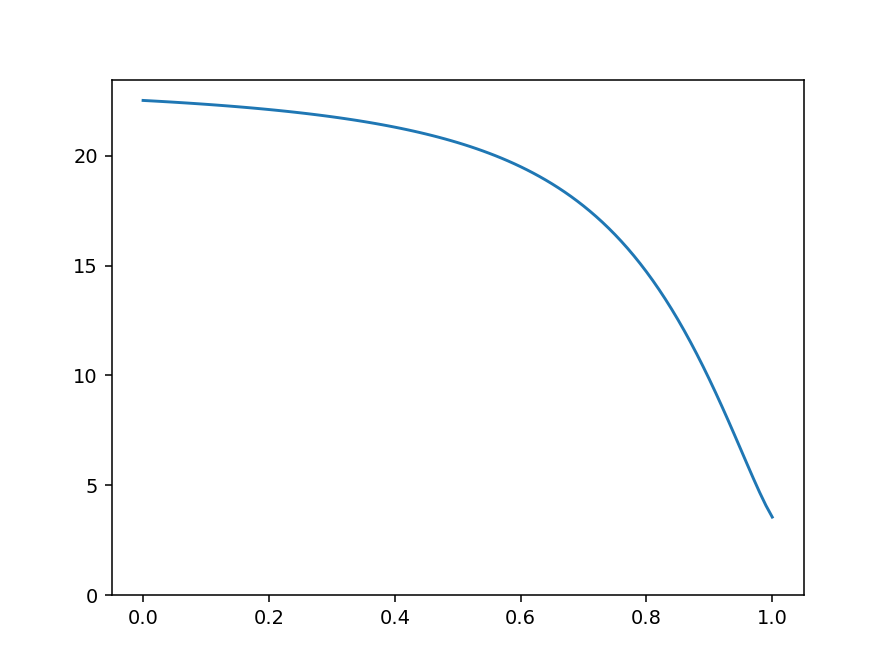

In [9]:
import matplotlib.pyplot as plt
nu_arr = np.linspace(0,10,101)
r_arr = np.linspace(0,1,101)
plt.figure()
plt.plot(r_arr,nu_max(r=r_arr,tau_A=0.005,tau_M=0.01))
plt.ylim([0,plt.ylim()[1]])
plt.show()

<IPython.core.display.Javascript object>


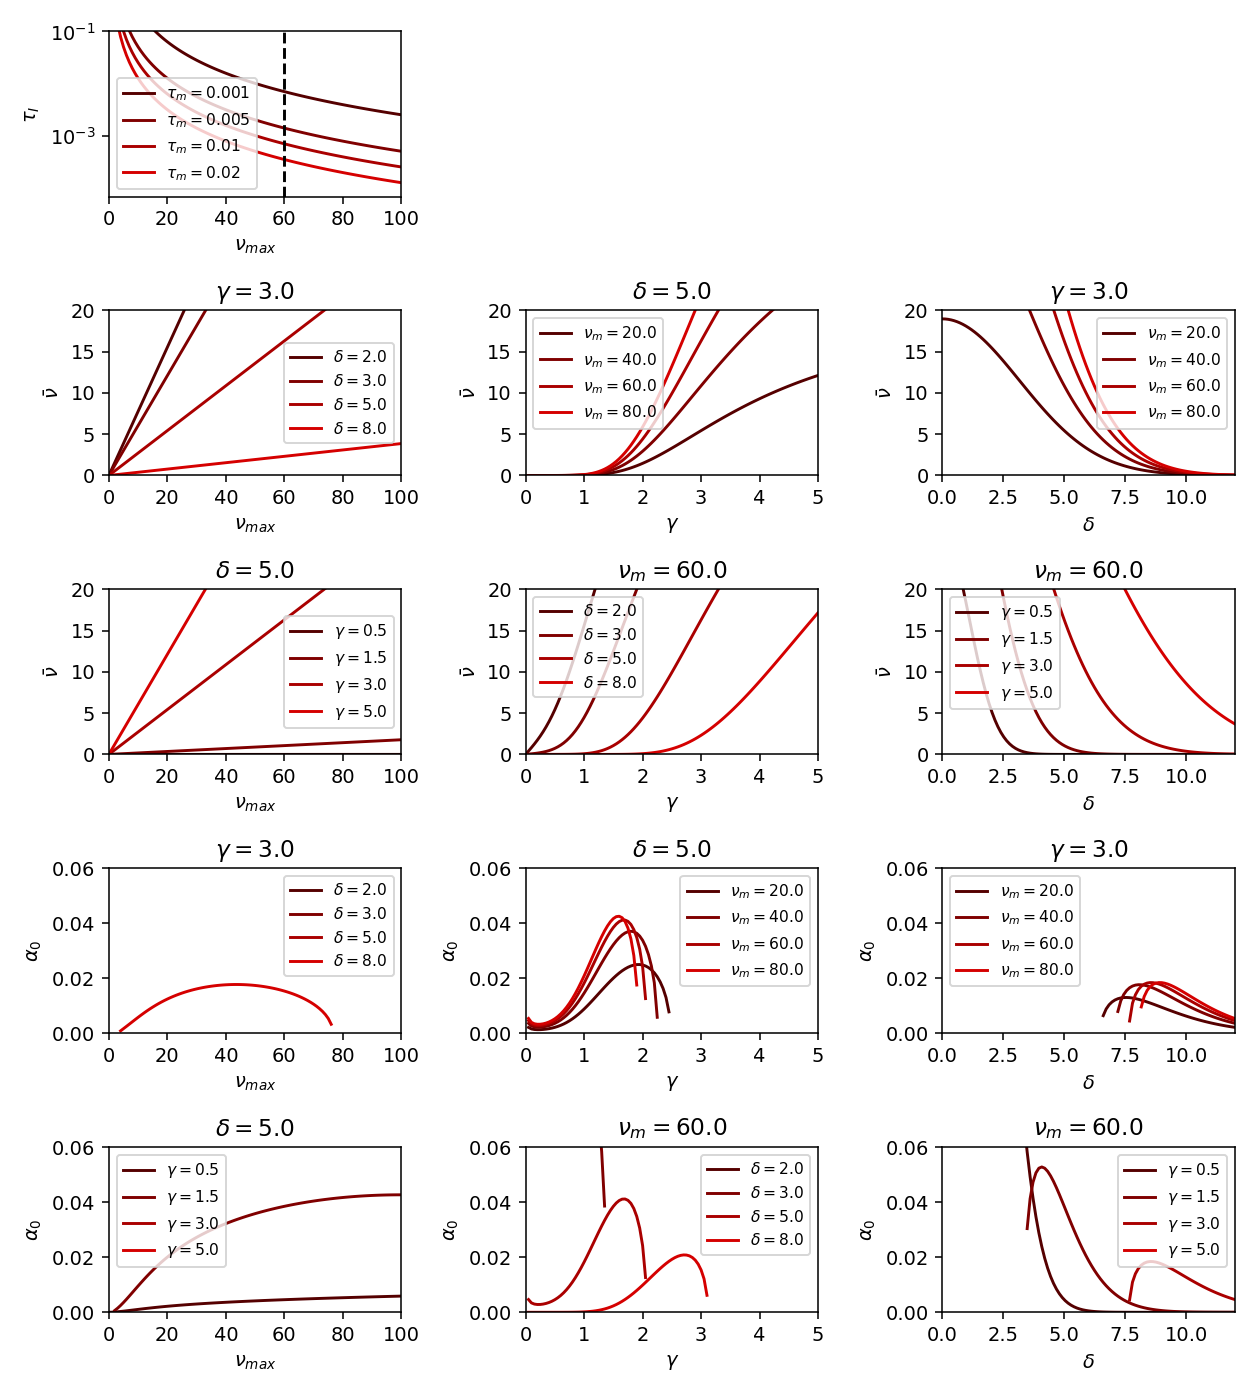

In [15]:
nu_max_arr = np.linspace(0,100,101)
gamma_arr = np.linspace(0,5,101)
delta_arr = np.linspace(0,12,101)

tau_m = [0.001,0.005,0.01,0.02]
#tau_I = get_tau_I(nu_max_arr,tau_m=tau_m)
#nu_mean = get_nu_bar(gamma=gamma,delta=delta,nu_max=nu_max)
#alpha_0 = get_alpha_0(gamma,delta,nu_max,tau_m,J_0=-1)

gamma_fix = [0.5,1.5,3.,5.]
delta_fix = [2.,3.,5.,8.]
nu_max_fix = [20.,40.,60.,80.]

idx_fix = 2

cols = 3
rows = 5
fig, ax = plt.subplots(rows,cols,figsize=(9,10))


#ax[0][0].plot(nu_max_arr,get_tau_I(nu_max_arr,tau_m=0.005),color=[0.8,0,0])
#ax[0][0].plot(nu_max_arr,get_tau_I(nu_max_arr,tau_m=0.001),color=[0.6,0,0])

ax[0][1].remove()
ax[0][2].remove()


for i in range(4):
    col = [(i+2)/6,0,0]
    
    ax[0][0].plot(nu_max_arr,get_tau_I(nu_max_arr,tau_m=tau_m[i]),color=col,label=f'$\\tau_m = {tau_m[i]}$')
    
    ax[1][0].plot(nu_max_arr,get_nu_bar(gamma=gamma_fix[idx_fix],delta=delta_fix[i],nu_max=nu_max_arr),color=col,label=f'$\\delta = {delta_fix[i]}$')
    ax[1][0].set_title(f'$\\gamma = {gamma_fix[idx_fix]}$')
    ax[1][1].plot(gamma_arr,get_nu_bar(gamma=gamma_arr,delta=delta_fix[idx_fix],nu_max=nu_max_fix[i]),color=col,label=f'$\\nu_m = {nu_max_fix[i]}$')
    ax[1][1].set_title(f'$\\delta = {delta_fix[idx_fix]}$')
    ax[1][2].plot(delta_arr,get_nu_bar(gamma=gamma_fix[idx_fix],delta=delta_arr,nu_max=nu_max_fix[i]),color=col,label=f'$\\nu_m = {nu_max_fix[i]}$')
    ax[1][2].set_title(f'$\\gamma = {gamma_fix[idx_fix]}$')
    
    ax[2][0].plot(nu_max_arr,get_nu_bar(gamma=gamma_fix[i],delta=delta_fix[idx_fix],nu_max=nu_max_arr),color=col,label=f'$\\gamma = {gamma_fix[i]}$')
    ax[2][0].set_title(f'$\\delta = {delta_fix[idx_fix]}$')
    ax[2][1].plot(gamma_arr,get_nu_bar(gamma=gamma_arr,delta=delta_fix[i],nu_max=nu_max_fix[idx_fix]),color=col,label=f'$\\delta = {delta_fix[i]}$')
    ax[2][1].set_title(f'$\\nu_m = {nu_max_fix[idx_fix]}$')
    ax[2][2].plot(delta_arr,get_nu_bar(gamma=gamma_fix[i],delta=delta_arr,nu_max=nu_max_fix[idx_fix]),color=col,label=f'$\\gamma = {gamma_fix[i]}$')
    ax[2][2].set_title(f'$\\nu_m = {nu_max_fix[idx_fix]}$')
    
    ax[3][0].plot(nu_max_arr,get_alpha_0(gamma=gamma_fix[idx_fix],delta=delta_fix[i],nu_max=nu_max_arr,tau_m=tau_m[idx_fix],J_0=-1),color=col,label=f'$\\delta = {delta_fix[i]}$')
    ax[3][0].set_title(f'$\\gamma = {gamma_fix[idx_fix]}$')
    ax[3][1].plot(gamma_arr,get_alpha_0(gamma=gamma_arr,delta=delta_fix[idx_fix],nu_max=nu_max_fix[i],tau_m=tau_m[idx_fix],J_0=-1),color=col,label=f'$\\nu_m = {nu_max_fix[i]}$')
    ax[3][1].set_title(f'$\\delta = {delta_fix[idx_fix]}$')
    ax[3][2].plot(delta_arr,get_alpha_0(gamma=gamma_fix[idx_fix],delta=delta_arr,nu_max=nu_max_fix[i],tau_m=tau_m[idx_fix],J_0=-1),color=col,label=f'$\\nu_m = {nu_max_fix[i]}$')
    ax[3][2].set_title(f'$\\gamma = {gamma_fix[idx_fix]}$')
        
    ax[4][0].plot(nu_max_arr,get_alpha_0(gamma=gamma_fix[i],delta=delta_fix[idx_fix],nu_max=nu_max_arr,tau_m=tau_m[idx_fix],J_0=-1),color=col,label=f'$\\gamma = {gamma_fix[i]}$')
    ax[4][0].set_title(f'$\\delta = {delta_fix[idx_fix]}$')
    ax[4][1].plot(gamma_arr,get_alpha_0(gamma=gamma_arr,delta=delta_fix[i],nu_max=nu_max_fix[idx_fix],tau_m=tau_m[idx_fix],J_0=-1),color=col,label=f'$\\delta = {delta_fix[i]}$')
    ax[4][1].set_title(f'$\\nu_m = {nu_max_fix[idx_fix]}$')
    ax[4][2].plot(delta_arr,get_alpha_0(gamma=gamma_fix[i],delta=delta_arr,nu_max=nu_max_fix[idx_fix],tau_m=tau_m[idx_fix],J_0=-1),color=col,label=f'$\\gamma = {gamma_fix[i]}$')
    ax[4][2].set_title(f'$\\nu_m = {nu_max_fix[idx_fix]}$')
    #ax[4][0].plot(delta_arr,get_nu_bar(gamma=gamma_fix[2],delta=delta_arr,nu_max=nu_max_fix[i]),color=col)

ax[0][0].axvline(60,color='k',linestyle='--')
ax[0][0].set_yscale('log')
plt.setp(ax[0][0],ylim=[ax[0][0].get_ylim()[0],0.1])
ax[0][0].legend(fontsize=8)

for col in range(cols):
    plt.setp(ax[0][col],ylabel='$\\tau_I$')
    plt.setp(ax[1][col],ylabel='$\\bar{\\nu}$',ylim=[0,20])
    plt.setp(ax[2][col],ylabel='$\\bar{\\nu}$',ylim=[0,20])
    plt.setp(ax[3][col],ylabel='$\\alpha_0$',ylim=[0,0.06])
    plt.setp(ax[4][col],ylabel='$\\alpha_0$',ylim=[0,0.06])
    #ax[0][col].legend()
    ax[1][col].legend(fontsize=8)
    ax[2][col].legend(fontsize=8)
    ax[3][col].legend(fontsize=8)
    ax[4][col].legend(fontsize=8)
    

for row in range(rows):
    plt.setp(ax[row][0],xlabel='$\\nu_{max}$',xlim=[nu_max_arr[0],nu_max_arr[-1]])
    plt.setp(ax[row][1],xlabel='$\\gamma$',xlim=[gamma_arr[0],gamma_arr[-1]])
    plt.setp(ax[row][2],xlabel='$\\delta$',xlim=[delta_arr[0],delta_arr[-1]])

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


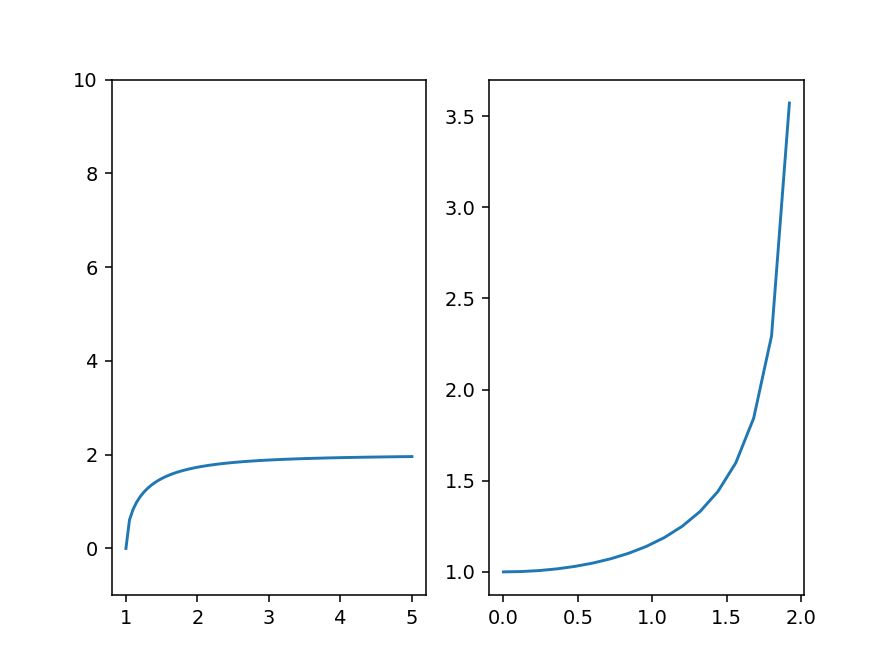

/tmp/ipykernel_108870/3442997572.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ax[0].plot(gamma_arr,np.sqrt(4*(gamma_arr**2-1)/gamma_arr**2))
/tmp/ipykernel_108870/3442997572.py:2: RuntimeWarning: invalid value encountered in sqrt
  ax[0].plot(gamma_arr,np.sqrt(4*(gamma_arr**2-1)/gamma_arr**2))
/tmp/ipykernel_108870/3442997572.py:3: RuntimeWarning: invalid value encountered in sqrt
  ax[1].plot(delta_arr,np.sqrt(4/(4-delta_arr**2)))


In [10]:
fig,ax = plt.subplots(1,2)
ax[0].plot(gamma_arr,np.sqrt(4*(gamma_arr**2-1)/gamma_arr**2))
ax[1].plot(delta_arr,np.sqrt(4/(4-delta_arr**2)))
plt.setp(ax[0],ylim=[-1,10])
plt.show()

In [11]:
np.log(1)

0.0